## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import sklearn

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: bgcho96 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Fixed RandomSeed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Load Data & Pre-Processing

In [4]:
csv_path = "../datasets/DACON_electricity_demand/"  
train_df = pd.read_csv(csv_path+'train.csv')
test_df= pd.read_csv(csv_path+'test.csv')
buildingInfo_df= pd.read_csv(csv_path+'building_info.csv')
# grad_grow = [1, 11, 13, 15, 31, 33, 34, 36, 45, 58, 61, 69, 70, 72, 73, 74, 78, 79, 80, 83, 84, 88, 90, 91, 93, 98, 100]
# hot_season = [10, 25, 57, 64, 67, 89]
# biweekly = [95]
# no_season = [4, 28, 30, 31, 33, 34, 35, 36, 54, 57, 58, 59, 62, 63, 65, 71, 73, 77, 78, 81, 82, 84, 85, 92, 93, 96, 97]
# weekend_sensitive = [2, 3, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 37, 38, 39, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 60, 64, 66, 67, 68, 69, 72, 75, 80, 83, 86, 87, 90, 91, 94, 99]
# occasional_off = [8, 19, 25, 30, 31, 40, 41, 52, 54, 67, 70, 72, 73, 74, 76, 78, 80, 92, 94, 97, 98]
# long_off = [7, 53, 67, 94]
# off_category = [9, 11, 56, 61, 81, 89, 100]
# monthly = [27]
# special_frequency = [29, 32, 40, 43, 59, 62, 63]
# label_map = {
#     'grad_grow': grad_grow,
#     'hot_season': hot_season,
#     'biweekly': biweekly,
#     'no_season': no_season,
#     'weekend_sensitive': weekend_sensitive,
#     'occasional_off': occasional_off,
#     'long_off': long_off,
#     'off_category': off_category,
#     'monthly': monthly,
#     'special_frequency': special_frequency
# }

# # 0/1 값으로 컬럼 추가
# for label, id_list in label_map.items():
#     buildingInfo_df[label] = buildingInfo_df['건물번호'].isin(id_list).astype(int)

In [5]:
buildingInfo_df

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,호텔,82912.71,77586.00,-,-,-
1,2,상용,40658.90,30392.82,-,-,-
2,3,병원,560431.00,418992.00,278.58,-,-
3,4,호텔,41813.29,23715.71,-,-,-
4,5,학교,403749.39,248507.00,1983.05,1025,250
...,...,...,...,...,...,...,...
95,96,건물기타,3260213.41,1956128.00,-,-,-
96,97,건물기타,42370.93,3975.52,81.38,-,-
97,98,호텔,99102.62,22097.00,-,-,-
98,99,상용,329867.95,13442.35,171.6,-,-


In [6]:
buildingInfo_df
# missing_values = ['-', '없음', 'N/A', '']

# # DataFrame 전체에 적용
# buildingInfo_df = buildingInfo_df.replace(missing_values, np.nan)
# buildingInfo_df = buildingInfo_df.drop(columns=['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)','연면적(m2)', '냉방면적(m2)'])
buildingInfo_df = buildingInfo_df.drop(columns=['ESS저장용량(kWh)', 'PCS용량(kW)'])
buildingInfo_df = buildingInfo_df.replace('-',0)
# cols = ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']
cols = ['태양광용량(kW)']

for col in cols:
    buildingInfo_df[col] = pd.to_numeric(buildingInfo_df[col], errors='coerce')

In [7]:
train_df = pd.merge(buildingInfo_df, train_df, on='건물번호', how='right')
test_df = pd.merge(buildingInfo_df, test_df, on='건물번호', how='right')
from sklearn.preprocessing import LabelEncoder
import numpy as np

label_encoders = {}
for col in ['건물유형']:
    if train_df[col].dtype == 'object':
        le = LabelEncoder()

        # NaN 제외하고 fit
        le.fit(train_df[col].dropna())

        # transform 시 NaN은 그대로 유지
        train_df[col] = train_df[col].map(lambda x: le.transform([x])[0] if pd.notna(x) else np.nan)
        test_df[col] = test_df[col].map(lambda x: le.transform([x])[0] if pd.notna(x) else np.nan)

        label_encoders[col] = le


In [8]:
test_df

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),num_date_time,일시,기온(°C),강수량(mm),풍속(m/s),습도(%)
0,1,9,82912.71,77586.0,0.0,1_20240825 00,20240825 00,26.5,0.0,0.7,80.0
1,1,9,82912.71,77586.0,0.0,1_20240825 01,20240825 01,26.1,0.0,0.0,80.0
2,1,9,82912.71,77586.0,0.0,1_20240825 02,20240825 02,25.9,0.0,0.3,83.0
3,1,9,82912.71,77586.0,0.0,1_20240825 03,20240825 03,25.7,0.0,1.1,83.0
4,1,9,82912.71,77586.0,0.0,1_20240825 04,20240825 04,25.5,0.0,1.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...
16795,100,9,162070.24,152943.0,0.0,100_20240831 19,20240831 19,27.1,0.0,2.7,68.0
16796,100,9,162070.24,152943.0,0.0,100_20240831 20,20240831 20,26.5,0.0,2.9,73.0
16797,100,9,162070.24,152943.0,0.0,100_20240831 21,20240831 21,26.3,0.0,3.5,73.0
16798,100,9,162070.24,152943.0,0.0,100_20240831 22,20240831 22,26.0,0.0,3.4,68.0


In [9]:
#시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
train_df['month'] = train_df['일시'].apply(lambda x : int(x[4:6]))
train_df['day'] = train_df['일시'].apply(lambda x : int(x[6:8]))
train_df['time'] = train_df['일시'].apply(lambda x : int(x[9:11]))

In [10]:
train_x = train_df.drop(columns=['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'])
train_y = train_df['전력소비량(kWh)']

In [11]:
# 시계열 특성을 학습에 반영하기 위해 test 데이터도 동일하게 처리합니다
test_df['month'] = test_df['일시'].apply(lambda x : int(x[4:6]))
test_df['day'] = test_df['일시'].apply(lambda x : int(x[6:8]))
test_df['time'] = test_df['일시'].apply(lambda x : int(x[9:11]))

In [12]:
test_x = test_df.drop(columns=['num_date_time', '일시'])
train_x['태양광용량(kW)'] = pd.to_numeric(train_x['태양광용량(kW)'], errors='coerce')
test_x['태양광용량(kW)'] = pd.to_numeric(test_x['태양광용량(kW)'], errors='coerce')

In [13]:
train_x

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),기온(°C),강수량(mm),풍속(m/s),습도(%),month,day,time
0,1,9,82912.71,77586.0,0.0,18.3,0.0,2.6,82.0,6,1,0
1,1,9,82912.71,77586.0,0.0,18.3,0.0,2.7,82.0,6,1,1
2,1,9,82912.71,77586.0,0.0,18.1,0.0,2.6,80.0,6,1,2
3,1,9,82912.71,77586.0,0.0,18.0,0.0,2.6,81.0,6,1,3
4,1,9,82912.71,77586.0,0.0,17.8,0.0,1.3,81.0,6,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,9,162070.24,152943.0,0.0,29.1,0.0,4.4,76.0,8,24,19
203996,100,9,162070.24,152943.0,0.0,28.6,0.0,3.7,74.0,8,24,20
203997,100,9,162070.24,152943.0,0.0,28.3,0.0,2.9,74.0,8,24,21
203998,100,9,162070.24,152943.0,0.0,28.0,0.0,1.7,76.0,8,24,22


## Train

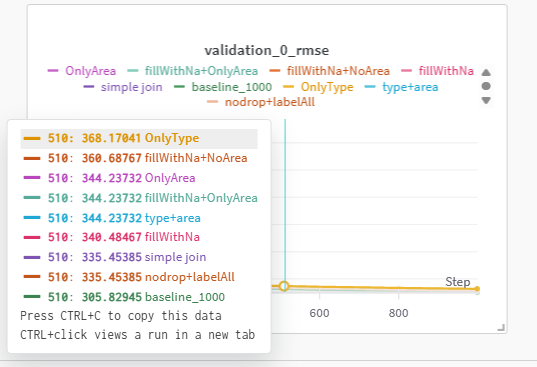

In [35]:
train_x['태양광용량(kW)'].unique()

array([   0.  ,  278.58, 1983.05,  389.76,  217.92, 1349.03,  276.  ,
        849.78, 1974.71,   97.  ,  100.  ,  255.88,  879.82,  858.02,
        953.4 ,   83.95,   97.85,  344.96,  342.  ,   12.24,   83.2 ,
         74.25,  140.6 ,   77.76,  198.56,   10.08,  218.88, 1039.86,
        105.  ,  215.89, 1397.02,  199.4 ,  219.6 ,  820.  ,  540.57,
         50.88,   94.38, 1297.98, 1340.1 ,  103.  ,  419.2 ,   36.  ,
        790.08,  605.  ,  495.  ,  282.95,   38.88,   77.38,  168.  ,
        322.9 ,   99.64,   20.25,   81.38,  171.6 ])

In [14]:
import wandb
from xgboost.callback import TrainingCallback
import numpy as np
import xgboost as xgb

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred)
    return np.mean(np.where(denominator == 0, 0, 2.0 * diff / denominator)) * 100

class WandbSmapeCallback(TrainingCallback):
    def __init__(self, X_eval, y_eval, name="train"):
        self.X_eval = X_eval
        self.y_eval = y_eval
        self.name = name

    def after_iteration(self, model, epoch, evals_log):
        # 예측값 계산
        y_pred = model.predict(xgb.DMatrix(self.X_eval))
        # SMAPE 계산
        smape_value = smape(self.y_eval, y_pred)
        # RMSE 계산
        rmse_value = np.sqrt(np.mean((self.y_eval - y_pred) ** 2))
        # wandb에 동시에 로그 기록
        wandb.log({
            f"{self.name}_SMAPE": smape_value,
            f"{self.name}_RMSE": rmse_value
        }, step=epoch)

        return False  # 학습 계속

wandb.init(project="xgb-wandb", name = "droppcsess+dash2zero+1000")
# wandb.init(project="xgb-wandb", name="smape-tracking")

model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    random_state=42,
    eval_metric="rmse",  # 기본 RMSE도 로그됨
    callbacks=[
        WandbSmapeCallback(train_x, train_y, name="train")  # ← SMAPE 로그용 콜백
    ]
)

model.fit(train_x, train_y, eval_set=[(train_x, train_y)])

wandb.finish()

[0]	validation_0-rmse:3366.71443
[1]	validation_0-rmse:3080.76216
[2]	validation_0-rmse:2824.07596
[3]	validation_0-rmse:2601.48115
[4]	validation_0-rmse:2406.85531
[5]	validation_0-rmse:2233.52877
[6]	validation_0-rmse:2082.98266
[7]	validation_0-rmse:1947.86223
[8]	validation_0-rmse:1818.18103
[9]	validation_0-rmse:1708.05795
[10]	validation_0-rmse:1612.01387
[11]	validation_0-rmse:1520.71711
[12]	validation_0-rmse:1442.51826
[13]	validation_0-rmse:1375.98695
[14]	validation_0-rmse:1320.93425
[15]	validation_0-rmse:1266.83759
[16]	validation_0-rmse:1219.57795
[17]	validation_0-rmse:1179.27906
[18]	validation_0-rmse:1140.81234
[19]	validation_0-rmse:1098.47092
[20]	validation_0-rmse:1069.90961
[21]	validation_0-rmse:1044.38892
[22]	validation_0-rmse:1020.89503
[23]	validation_0-rmse:998.95565
[24]	validation_0-rmse:978.34917
[25]	validation_0-rmse:953.20563
[26]	validation_0-rmse:935.38859
[27]	validation_0-rmse:923.39857
[28]	validation_0-rmse:907.78271
[29]	validation_0-rmse:896.610

train_RMSE,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_SMAPE,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_RMSE,284.25037
train_SMAPE,10.91876


In [ ]:
model = XGBRegressor()
model.fit(train_x, train_y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Prediction

In [17]:
preds = model.predict(test_x)

## Submission

In [18]:
submission = pd.read_csv(csv_path+'./sample_submission.csv')
submission['answer'] = preds

In [21]:
submission.to_csv('../toBeSubmit/baseline_submission_dropPCSESS_mycols_1000.csv', index=False)